# Jacobian at initialization

Here, we compute the norm of the product of the Jacobian at initialization with a signal and noise. For both deep decoder and deep image prior, this quantity is significantly smaller for noise than for a natural image. Thus, a natural image is better aligned with the leading singular vectors of the Jacobian than noise. This demonstrates that the Jacobian of the networks is approximately low-rank, with natural images lying in the space spanned by the leading singularvectors.

Running the DIP part requires the models from [https://github.com/DmitryUlyanov/deep-image-prior](https://github.com/DmitryUlyanov/deep-image-prior).

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from models import *

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 1


## Load image

In [2]:
path = './test_data/'
#img_name = "astronaut"
#img_name = "mri"
img_name = "phantom256"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)

#img_pil = load_and_crop(img_path,target_width=256,target_height=256)

img_np = pil_to_np(img_pil)
img_np = img_np / np.max(img_np)
img_clean_var = np_to_var(img_np).type(dtype)
print(img_clean_var.shape)
print(np.max(img_np))

torch.Size([1, 1, 256, 256])
1.0


## Functions to generate noisy image and noise

In [3]:
def get_noisy_img(sig=30,noise_same = False):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape)

    img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float32)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np,img_noisy_var

def get_noise(sig=30,noise_same = False,sh=None):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        if sh is None:
            sh = img_np.shape[1:]
        noise = np.random.rand(sh[0],sh[1]) #np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        if sh is None:
            sh = img_np.shape
        noise = np.random.rand(sh[0],sh[1],sh[2]) # np.random.normal(scale=sigma, size=img_np.shape)

    img_noisy_np = np.clip( noise , 0, 1).astype(np.float32)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np,img_noisy_var

img_noisy_np,img_noisy_var = get_noisy_img()  
output_depth = img_np.shape[0] 
print("Image size: ", img_np.shape)

img_np, img_var = get_noise(sig=30,noise_same = False,sh=None)
# make sure the norm is the same
img_var *= torch.norm(img_clean_var)/torch.norm(img_var) 

torch.norm(img_var), torch.norm(img_clean_var)

Image size:  (1, 256, 256)


(tensor(85.7806, device='cuda:0'), tensor(85.7806, device='cuda:0'))

In [4]:
numit = 5000

In [5]:
def tikz_hist(res,bins=100,filename="data.csv"):
    hist = plt.hist(res,normed=True, bins=bins)
    plt.show()
    x = np.array([ (hist[1][i] + hist[1][i+1])/2 for i in range(bins) ])
    y = np.array(hist[0])
    np.savetxt(filename, np.vstack([ x , y ]).T , delimiter="\t")

## Jacobian

In [6]:
num_channels = [256]*4

def get_net_input(num_channels=[256]*4,upsample=True):
    if upsample:
        totalupsample = 2**len(num_channels)
    else:
        totalupsample = 1
    width = int(img_clean_var.data.shape[2]/totalupsample)
    height = int(img_clean_var.data.shape[3]/totalupsample)
    shape = [1,num_channels[0], width, height]
    print("input shape: ", shape)
    net_input = Variable(torch.zeros(shape)).type(dtype)
    net_input.data.uniform_()
    net_input.data *= 1./10
    return net_input

net_input = get_net_input(num_channels)

input shape:  [1, 256, 16, 16]


In [7]:
def get_jacobian(net, x, noutputs):
    x = x.squeeze()
    n = x.size()[0]
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = net(x)
    y.backward(torch.eye(noutputs))
    return x.grad.data

In [8]:
def grad_norm(net):  
    # returns the norm of the gradient corresponding to the convolutional parameters
    
    # count number of convolutional layers
    nconvnets = 0
    for p in list(filter(lambda p: len(p.data.shape)>2, net.parameters())):
        nconvnets += 1
    
    out_grads = np.zeros(nconvnets)
    p = [x for x in net.parameters() ]
    for ind,p in enumerate(list(filter(lambda p: p.grad is not None and len(p.data.shape)>2, net.parameters()))):
        out_grads[ind] = p.grad.data.norm(2).item()

    return np.linalg.norm( out_grads )    

def get_jacobinanprodsDD(img_var,numit=100):
    res = []
    for i in range(numit):
        net = decodernw(1,num_channels_up=num_channels).type(dtype)
        out = net(net_input).type(dtype)
        out.backward( img_var )
        res += [grad_norm(net)]
    return res

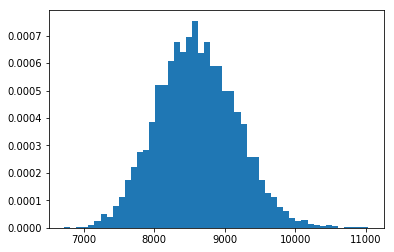

In [9]:
imgjprods = get_jacobinanprodsDD(img_clean_var,numit=numit)

tikz_hist(imgjprods,bins=50,filename="JacobianCleanImg.csv")

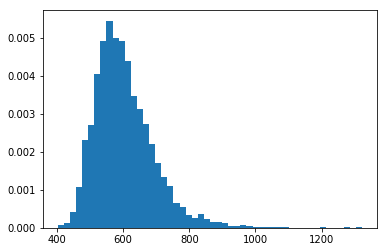

In [10]:
imgjprods = get_jacobinanprodsDD(img_var,numit=numit)

tikz_hist(imgjprods,bins=50,filename="JacobianNoiseImg.csv")

## DIP

In [11]:
num_channels = [32]*5
net_input = get_net_input(num_channels,False)

def get_jacobinanprodsDIP(img_var,numit=numit):
    res = []
    for i in range(numit):        
        net = get_net(32, 'skip', 'reflection',n_channels=output_depth,skip_n33d=128,
              skip_n33u=128,skip_n11=4,num_scales=5,upsample_mode='bilinear').type(dtype)   
        out = net(net_input).type(dtype)
        out.backward( img_var )
        res += [grad_norm(net)]
    return res

input shape:  [1, 32, 256, 256]


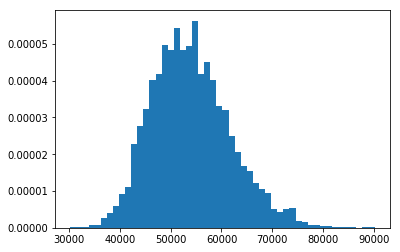

In [12]:
imgjprods = get_jacobinanprodsDIP(img_clean_var,numit=numit)

tikz_hist(imgjprods,bins=50,filename="JacobianCleanImgDIP.csv")

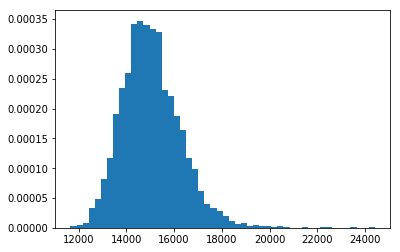

In [13]:
imgjprods = get_jacobinanprodsDIP(img_var,numit=numit)

tikz_hist(imgjprods,bins=50,filename="JacobianNoiseImgDIP.csv")